## Final Project

In [1]:
import IPython
import numpy as np
import scipy as sp
from scipy import signal
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt  
import sklearn
import peakutils
import csv 

%pylab inline
%matplotlib inline  


Populating the interactive namespace from numpy and matplotlib


In [133]:
# a few useful constants
fa = 32
fb = 64
ft = 4
fe = 4
m = 60 # seconds in a min

with open(r'/Users/dkvoso/Documents/ES155 Project/ACC67.csv', "rb") as f:
    data = list(csv.reader(f))
    acc_data = np.array(data[2:]).astype(np.float)
    x_acc=acc_data[4*fa:,0]
    y_acc=acc_data[4*fa:,1]
    z_acc=acc_data[4*fa:,2]
    
with open(r'/Users/dkvoso/Documents/ES155 Project/BVP67.csv', "rb") as f:
    data = list(csv.reader(f))
    bvp = np.array(data[2:]).astype(np.float)
    fbvp = 64 #sampling rate
    bvp=bvp[4*fb:,0]
    
with open(r'/Users/dkvoso/Documents/ES155 Project/EDA67.csv', "rb") as f:
    data = list(csv.reader(f))
    eda = np.array(data[2:]).astype(np.float)
    eda=eda[4*fe:,0]
    
with open(r'/Users/dkvoso/Documents/ES155 Project/TEMP67.csv', "rb") as f:
    data = list(csv.reader(f))
    temp = np.array(data[2:]).astype(np.float)
    temp=temp[4*ft:,0]

accm = np.sqrt(x_acc**2+y_acc**2+z_acc**2)
timea = np.arange(np.size(accm))*float(1)/fa
timeb=np.arange(len(bvp))*(float(1)/fb)
timee = np.arange(len(eda))*(float(1)/fe)
timet = np.arange(len(temp))*(float(1)/ft)



In [3]:
# Define Functions

# function to split long data into epochs 
# inputs the dataset, the length of the epoch, and the sampling frequency
def epoch(func,t,fs):
    func_epoch = func[:t*fs]
    for i in np.arange(np.size(func)/(t*fs)-1)+1: # for the number of epochs of that length
        func_epoch = np.vstack((func_epoch,func[i*t*fs:(i+1)*t*fs]))
    return func_epoch

# function to find zero crossings 
# inputs the matrix of epochs 
def ZC(func_epoch):
    ZC = []
    for i in np.arange(np.size(func_epoch,axis=0)):
        counter = 0
        for j in np.arange(np.size(func_epoch,axis=1)-1):
            zci = func_epoch[i,j]*func_epoch[i,j+1]
            if zci < 0: 
                counter += 1
        ZC = np.asarray(np.append(ZC,counter))
    return ZC

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y 

def binary_filter(y, x0, sig0, N, sigma2):
    '''
    A binary filter that takes
    y - data
    x0 - initial condition on mean
    sig0 - initial condition on varianace
    N - number of samples in data
    sigma2 - parameter sigma^2
    and outputs the filtered estimate p_t|t
    '''
    x10 = x0
    sig10 = sig0 + sigma2
    n = len(y)
    sig = np.empty(n)
    x = np.empty(n)
    p = np.empty(n)
    for t in xrange(n):
        p10 = np.exp(x10)/(1. + np.exp(x10))
        sig[t] = 1./(1/sig10 + N*p10*(1-p10))
        x[t] = x10 + sig[t]*(y[t]-N*p10)
        p[t] = np.exp(x[t])/(1. + np.exp(x[t]))
        x10 = x[t]
        sig10 = sig[t] + sigma2
    return p
def chunks(array, n):
    '''
    function for dividing the detected peaks.
    array - the array to be divided
    n - number of samples per chunk
    n  = #seconds that you want to window * Fs of ACC
    '''
    sub_set = []
    for i in range(0, len(array), n):
        sub_set.append(np.sum(array[i:i+n]))
    return np.array(sub_set)


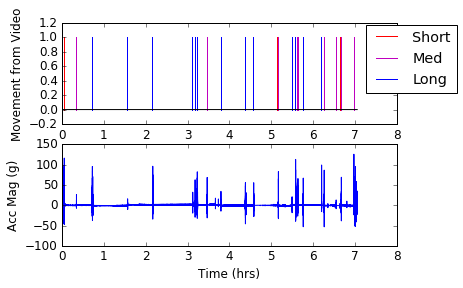

In [4]:
# manually input when I detected camera movement 

m = 60
hr = 3600
matplotlib.rcParams.update({'font.size': 12})

# times in starting hr,min,s,length
movetimes = np.array(([0,2,41,1],[0,20,8,6],[0,42,52,20],[1,33,26,15],[2,9,20,18],
                     [3,6,41,16],[3,10,3,18],[3,10,51,1],[3,13,15,11],[3,13,41,1],
                     [3,27,28,8],[3,47,13,17],[4,22,3,26],[4,33,55,19],[5,8,29,1],
                     [5,9,37,10],[5,29,5,17],[5,34,8,12],[5,37,19,1],[5,37,31,10],
                     [5,45,8,12],[6,10,48,1],[6,11,28,15],[6,15,11,9],[6,32,26,5],
                     [6,37,53,1],[6,39,48,7],[6,57,53,8]))
cam = zeros(len(accm))
lab = zeros(len(accm))

for i in np.arange(np.size(movetimes,axis=0)):
    tstart = fa*(hr*movetimes[i][0]+m*movetimes[i][1]+movetimes[i][2])
    tend = tstart+fa*movetimes[i][3]
    if movetimes[i][3] < 5:
        cam[tstart:tend] = 1
        lab[tstart:tend] = 1
    elif movetimes[i][3] > 10:
        cam[tstart:tend] = 1
        lab[tstart:tend] = 3
    else:
        cam[tstart:tend] = 1
        lab[tstart:tend] = 2

subplot(2,1,1)
plt.plot(timea[lab==0]/float(hr),cam[lab==0],'k')
plt.vlines(timea[lab==1]/float(hr),0,cam[lab==1],'r',label='Short')
plt.vlines(timea[lab==2]/float(hr),0,cam[lab==2],'m',label='Med')
plt.vlines(timea[lab==3]/float(hr),0,cam[lab==3],'b',label='Long')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.ylim(-0.2,1.2)
plt.ylabel('Movement from Video')
subplot(2,1,2)
plt.plot(timea/float(hr),demean(accm,axis=0))
plt.xlabel('Time (hrs)')
plt.ylabel('Acc Mag (g)')
plt.show()

In [5]:
# Separate into epochs and find zero crossings 

xacc_epoch = epoch(x_acc,30,fa)
xZC = ZC(xacc_epoch)
yacc_epoch = epoch(y_acc,30,fa)
yZC = ZC(yacc_epoch)
zacc_epoch = epoch(z_acc,30,fa)
zZC = ZC(zacc_epoch)

ZCtot = np.asarray(xZC+yZC+zZC)/3


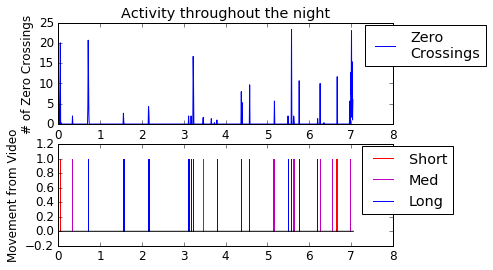

In [6]:
# Plot the zero crossings 

subplot(2,1,1)
#plt.plot(np.arange(np.size(x_acc)/(30*fa))*float(30)/hr,xZC,'k',label='X-Acc')
#plt.plot(np.arange(np.size(x_acc)/(30*fa))*float(30)/hr,yZC,'b',label='Y-Acc')
#plt.plot(np.arange(np.size(x_acc)/(30*fa))*float(30)/hr,zZC,'r',label='Z-Acc')
plt.plot(np.arange(np.size(x_acc)/(30*fa))*float(30)/hr,ZCtot,'b',label='Zero\nCrossings')
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.ylabel('# of Zero Crossings')
plt.title('Activity throughout the night')
subplot(2,1,2)
plt.plot(timea[lab==0]/float(hr),cam[lab==0],'k')
plt.vlines(timea[lab==1]/float(hr),0,cam[lab==1],'r',label='Short')
plt.vlines(timea[lab==2]/float(hr),0,cam[lab==2],'m',label='Med')
plt.vlines(timea[lab==3]/float(hr),0,cam[lab==3],'b',label='Long')
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.ylim(-0.2,1.2)
plt.ylabel('Movement from Video')

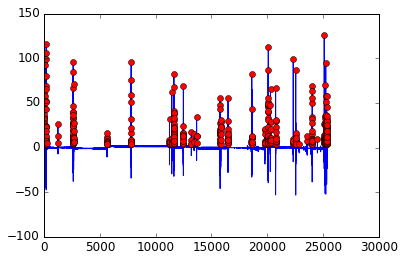

In [88]:
# find peaks of acceleration
accdm = pylab.demean(accm)
peaksa = peakutils.indexes(accdm,thres=0.02,min_dist=10)
peaktimesa = (np.asarray(peaksa))*float(1)/fa
ACC_Binary = np.zeros(accdm.shape)
ACC_Binary[peaksa] = 1

plt.plot(timea,accdm)
plt.plot(peaktimesa,accdm[peaksa],'ro')
#plt.xlim([5500,5700])
plt.show()

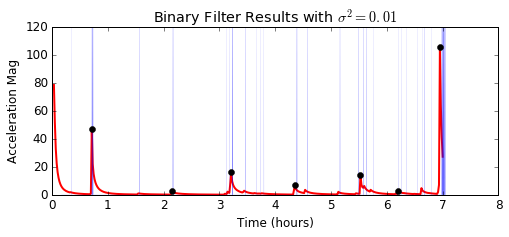

In [95]:
# use a binary filter on acceleration

total_time_seconds = 420.0*60.0
window_size = 1*60*fa # 1 minute * 60 s/m * sampling rate
sub_set = chunks(ACC_Binary, window_size)
time = np.linspace(0,total_time_seconds/hr,sub_set.shape[0])

for i in [.01]:
    pW = binary_filter(sub_set, 0, 0, window_size, sigma2=i)
    plt.figure(figsize=[8,3])
    plt.plot(time[2:],pW[2:]*fa*60,'r',lw=2)
    
    # Get the ylim of the plot
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    
    plt.plot(timea[2*60*5*fa:]/hr, ACC_Binary[2*60*5*fa:]*ymax, alpha = 0.6, lw=0.1)
    plt.title(r'Binary Filter Results with $\sigma^2 = %s$' % i)
    plt.xlabel('Time (hours)')
    plt.ylabel('Acceleration Mag')
    #plt.xlim([timeb[2*60*5*fb], total_time_seconds])
    #plt.xlim([7700,7900])
    
    

peaks_filt = peakutils.indexes(pW,thres=0.006,min_dist=fa)
plt.plot(time[peaks_filt],pW[peaks_filt]*fa*60,'ko')
plt.show()

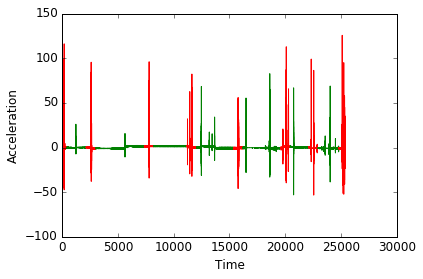

[0, 13440, 69120, 96000, 236160, 263040, 359040, 385920, 491520, 518400, 627840, 654720, 706560, 733440, 792960]


In [96]:
# use peaks to separate data into 10 min chunks around the peaks and then everything else 

# for each peak 
# first segment is everything until 5 min before peak 
# next segment is the 10 min window 
# then everything until 5 min before next peak 

#for i in peaks_filt

wake_seg = 7 #min
trans = []

trans.append(0)
trans.append(wake_seg*60*fa)
for i in peaks_filt[:-1]:
    trans.append((i-wake_seg)*60*fa)
    trans.append((i+wake_seg)*60*fa)
trans.append((peaks_filt[-1]-wake_seg)*60*fa)
if peaks_filt[-1] < len(sub_set)-5:
    i = peaks_filt[-1]
    trans.append((i+wake_seg)*60*fa)

col = ['red','green']
for i in np.arange(len(trans)-1):
    t = timea[trans[i]:trans[i+1]]
    y = accdm[trans[i]:trans[i+1]]
    plt.plot(t,y,color=col[i%2])
plt.plot(timea[trans[-1]:],accdm[trans[-1]:],color=col[(1-i)%2])

plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.show()
print trans


In [135]:
# Find BVP Peaks and heart rate

# find peaks
bvpdm = pylab.demean(bvp)
peaksb = peakutils.indexes(bvpdm,thres=0.2/max(bvpdm),min_dist=45)
peaktimesb = (np.asarray(peaksb)+1)*float(1)/fb
#print m*fb*np.size(peaksb)/np.size(ts1) #average HR over entire interval

# calculate heart rate using time between two peaks
win = 1
dist = []
for i in np.arange(len(peaksb)-win):
    dist.append(peaksb[i+win]-peaksb[i])
hrt = float(1)*win*m*fb/np.asarray(dist)
meanhr = np.mean(hrt)



57.2930398699


55.9268867925


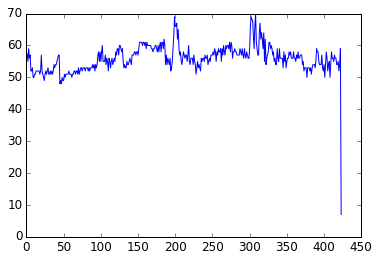

In [169]:
BVP_Binary = np.zeros(bvpdm.shape)
BVP_Binary[peaksb] = 1

window_size = 60*fb # 30 s/m * sampling rate
sub_set = chunks(BVP_Binary, window_size)
hrt = sub_set*fb/window_size*60
print np.mean(hrt)
plt.plot(hrt)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


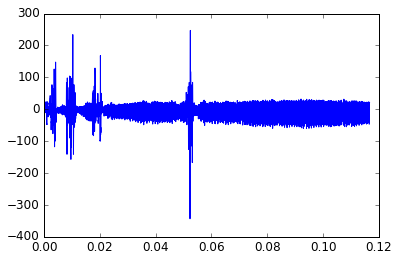

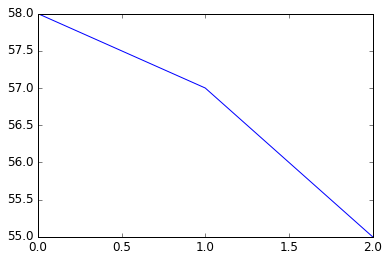

56.6666666667
1.24721912892


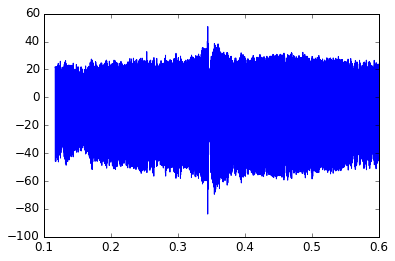

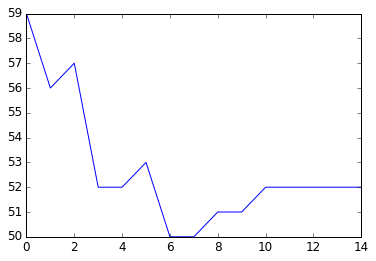

52.7333333333
2.48908729368


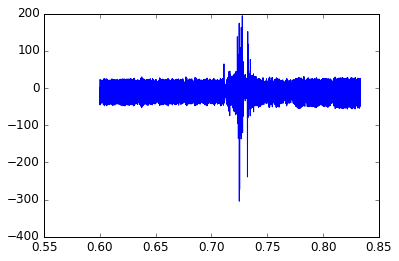

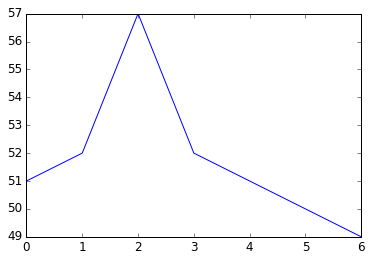

51.7142857143
2.37332110369


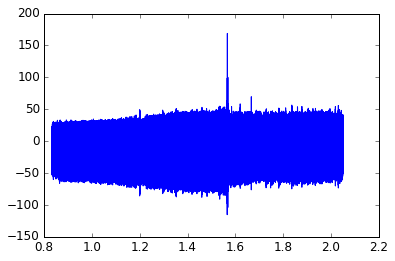

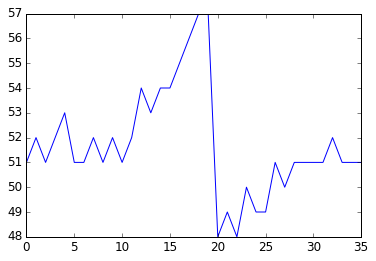

51.7222222222
2.15524052681


In [177]:
# separate the hr into the segments and see their means and variances 



for ind in range(0,len(trans)-11):
    start = trans[ind]*float(fb)/(fa)
    stop = trans[ind+1]*float(fb)/(fa)
    plt.plot(timeb[start:stop]/hr,bvp[start:stop])
    plt.show()
    start = trans[ind]/(60*fb)
    stop = trans[ind+1]/(60*fb)
    plt.plot(hrt[start:stop])
    plt.show()
    print np.mean(hrt[start:stop])
    print np.std(hrt[start:stop])

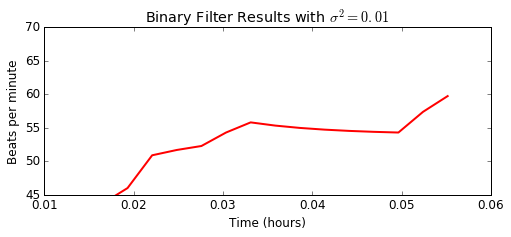

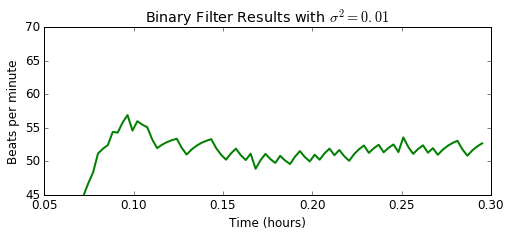

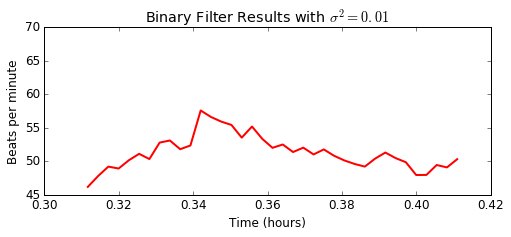

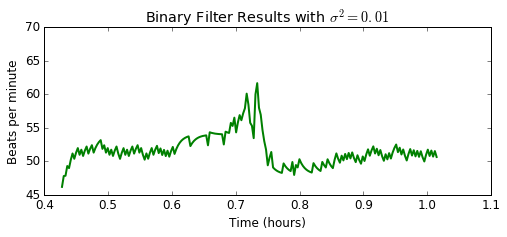

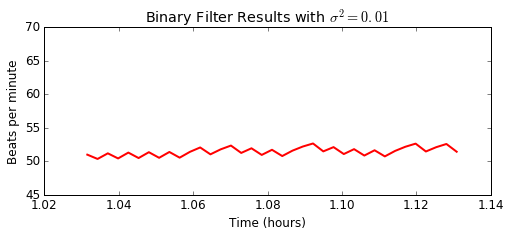

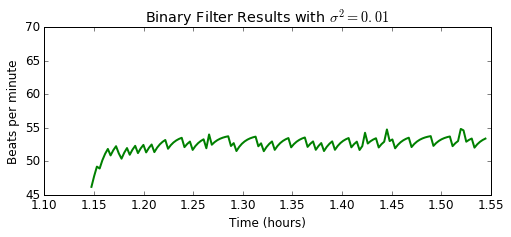

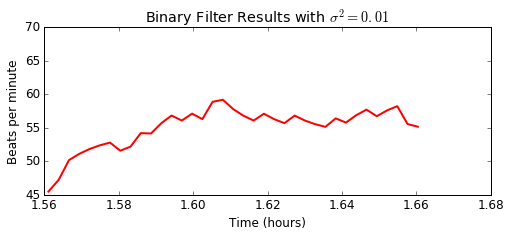

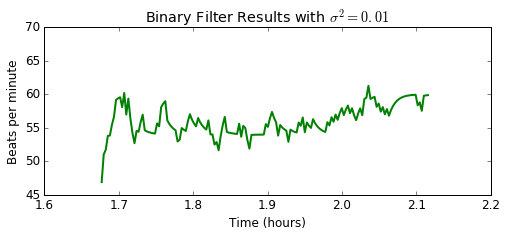

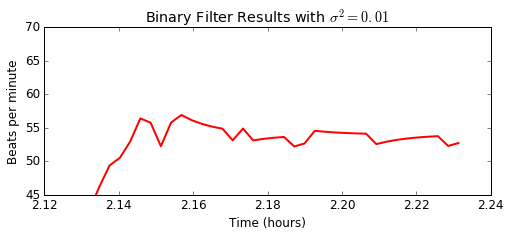

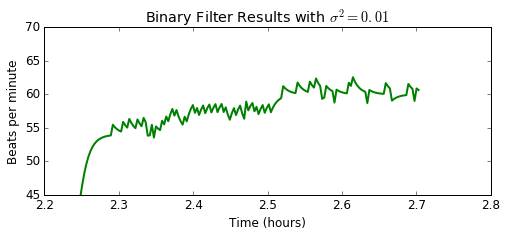

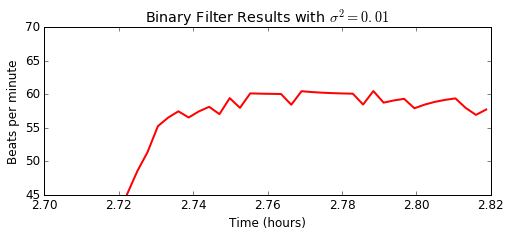

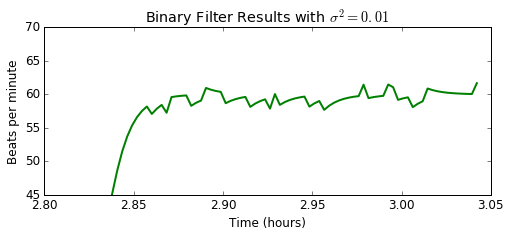

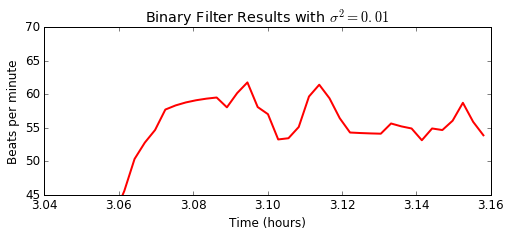

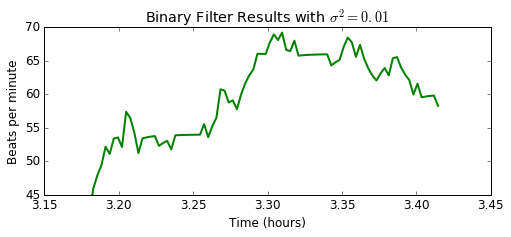

In [111]:
# use binary filter on sections

BVP_Binary = np.zeros(bvpdm.shape)
BVP_Binary[peaksb] = 1

total_time_seconds = 420*60
window_size = 10*fb # 30 s/m * sampling rate
sub_set = chunks(BVP_Binary, window_size)
time = np.linspace(0,total_time_seconds/float(hr),sub_set.shape[0])

col = ['red','green']
for ind in range(0,len(trans)-1):
    i = 0.01
    start = trans[ind]/window_size
    stop = trans[ind+1]/window_size
    pW = binary_filter(sub_set[start:stop], 40, 0, window_size, sigma2=i)
    plt.figure(figsize=[8,3])
    plt.plot(time[start+5:stop],pW[5:]*fb*60,color=col[ind%2],lw=2)
    
    # Get the ylim of the plot
    axes = plt.gca()
    axes.set_ylim([45,70])
    
    #plt.plot(timeb[2*60*5*fb:], BVP_Binary[2*60*5*fb:]*ymax, alpha = 0.6, lw=0.05)
    plt.title(r'Binary Filter Results with $\sigma^2 = %s$' % i)
    plt.xlabel('Time (hours)')
    plt.ylabel('Beats per minute')
    #plt.xlim([timeb[2*60*5*fb], total_time_seconds])
    #plt.xlim([7700,7900])
    plt.show()

In [114]:
print range(2,len(trans)-1)[::2]

[2, 4, 6, 8, 10, 12]


49.3078554977
2.24864553914
49.1928579591
0.599414677667
53.1899609317
1.95670915124
51.4756613298
1.30765064178
55.8956131487
1.7398304582
54.042395505
2.41886132355
sleep
49.603127221
1.43370873691
49.3665190015
2.14095719417
50.27595781
0.824348340672
53.6301607594
2.00367345923
55.4359339778
2.53866612801
56.429534434
1.50685701737
57.3704587695
5.66907128318
means
52.1840573953
52.6659407203
3.04944833042
3.91748323811


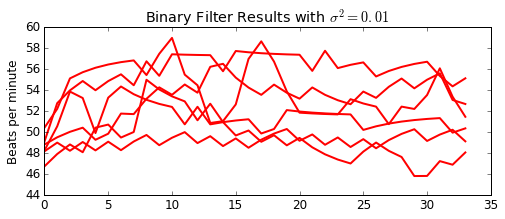

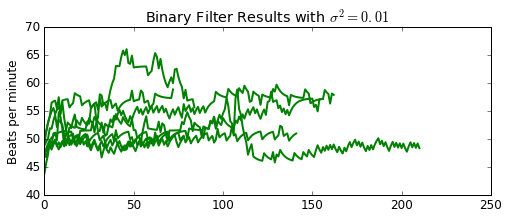

In [154]:
sleep = []
wake = []

col = ['red','green']
plt.figure(figsize=[8,3])
for ind in range(2,len(trans)-1)[::2]:
    i = 0.01
    start = trans[ind]/window_size
    stop = trans[ind+1]/window_size
    pW = binary_filter(sub_set[start:stop], 40, 0, window_size, sigma2=i)
    plt.plot(pW[8:]*fb*meanhr,color=col[ind%2],lw=2)
    wake.append(pW[8:]*fb*meanhr)
    # Get the ylim of the plot
    axes = plt.gca()
    #axes.set_ylim([45,70])
    
    #plt.plot(timeb[2*60*5*fb:], BVP_Binary[2*60*5*fb:]*ymax, alpha = 0.6, lw=0.05)
    plt.title(r'Binary Filter Results with $\sigma^2 = %s$' % i)
    plt.ylabel('Beats per minute')
    #plt.xlim([timeb[2*60*5*fb], total_time_seconds])
    #plt.xlim([7700,7900])
    print np.mean(pW[8:]*fb*meanhr)
    print np.std(pW[8:]*fb*meanhr)
print 'sleep'   
plt.figure(figsize=[8,3])
for ind in range(1,len(trans)-1)[::2]:
    i = 0.01
    start = trans[ind]/window_size
    stop = trans[ind+1]/window_size
    pW = binary_filter(sub_set[start:stop], 40, 0, window_size, sigma2=i)
    plt.plot(pW[8:]*fb*meanhr,color=col[ind%2],lw=2)
    sleep = np.concatenate((sleep,pW[8:]*fb*meanhr))
    # Get the ylim of the plot
    axes = plt.gca()
    #axes.set_ylim([45,70])
    
    #plt.plot(timeb[2*60*5*fb:], BVP_Binary[2*60*5*fb:]*ymax, alpha = 0.6, lw=0.05)
    plt.title(r'Binary Filter Results with $\sigma^2 = %s$' % i)
    plt.ylabel('Beats per minute')
    #plt.xlim([timeb[2*60*5*fb], total_time_seconds])
    #plt.xlim([7700,7900])
    print np.mean(pW[8:]*fb*meanhr)
    print np.std(pW[8:]*fb*meanhr)
    
print 'means'
print np.mean(wake)
print np.mean(sleep)
print np.std(wake)
print np.std(sleep)

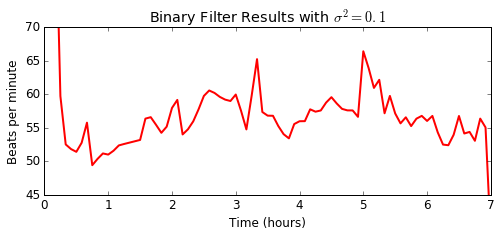

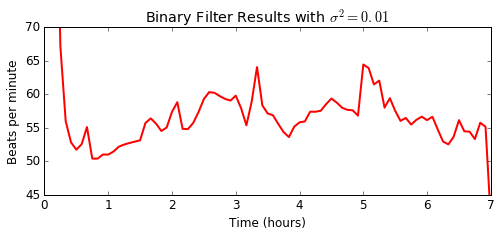

In [110]:
# use a binary filter 

BVP_Binary = np.zeros(bvpdm.shape)
BVP_Binary[peaksb] = 1

total_time_seconds = 420.0*60.0
window_size = 5*60*fb # 5 minutes * 60 s/m * sampling rate
sub_set = chunks(BVP_Binary, window_size)
time = np.linspace(0,total_time_seconds/hr,sub_set.shape[0])

for i in [0.1,0.01]:
    pW = binary_filter(sub_set, 0, 0, window_size, sigma2=i)
    plt.figure(figsize=[8,3])
    plt.plot(time[2:],pW[2:]*fb*60,'r',lw=2)
    
    # Get the ylim of the plot
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    
    #plt.plot(timeb[2*60*5*fb:], BVP_Binary[2*60*5*fb:]*ymax, alpha = 0.6, lw=0.05)
    plt.title(r'Binary Filter Results with $\sigma^2 = %s$' % i)
    plt.xlabel('Time (hours)')
    plt.ylabel('Beats per minute')
    #plt.xlim([timeb[2*60*5*fb], total_time_seconds])
    #plt.xlim([7700,7900])
    plt.show()

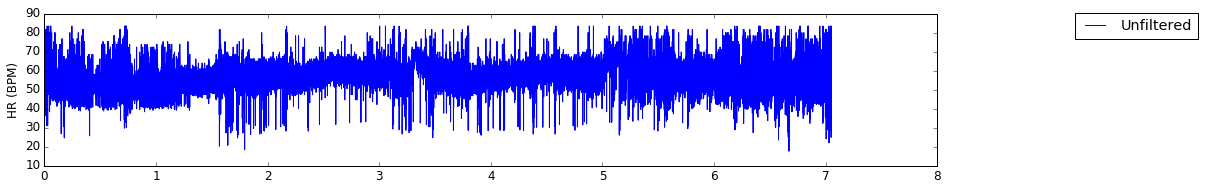

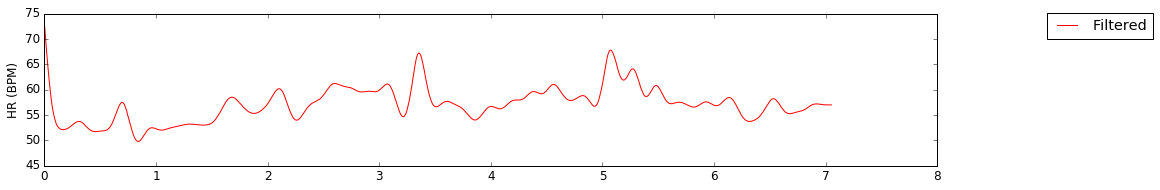

In [17]:
# smooth the heart rate calculation with a butterworth 
cutoff = .1
hrt_smooth = butter_lowpass_filtfilt(hrt, cutoff, fb)

plt.figure(figsize=[16,6])
subplot(2,1,1)
plt.plot(peaktimesb[:-win]/hr,hrt,label='Unfiltered')
plt.legend(bbox_to_anchor=(1.3, 1.05))
ylabel('HR (BPM)')
#plt.xlim([7700,7900])
plt.figure(figsize=[16,6])
subplot(2,1,2)
plt.plot(peaktimesb[:-win]/hr,hrt_smooth,'r',label='Filtered')
plt.legend(bbox_to_anchor=(1.25, 1.05))
ylabel('HR (BPM)')
#plt.xlim([7700,7900])
plt.show()


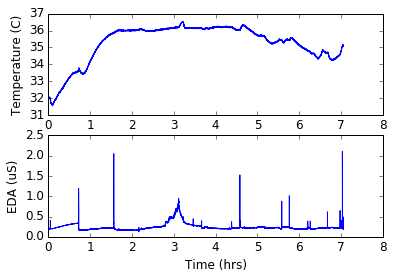

In [9]:
# Plot temperature and EDA
subplot(2,1,1)
plt.plot(timet/float(hr),temp)
plt.ylabel('Temperature (C)')
subplot(2,1,2)
plt.plot(timee/float(hr),eda)
plt.xlabel('Time (hrs)')
plt.ylabel('EDA (uS)')
plt.show()

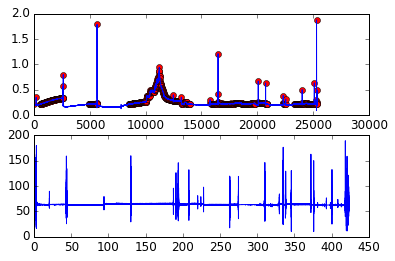

In [11]:
# EDA peaks

# find peaks

cutoff = 10
eda_smooth = butter_lowpass_filtfilt(eda, cutoff, fb)
#plt.plot(timee/m,eda_smooth)
#plt.show()

s1 = eda_smooth[:]
ts1 = timee[:]
peakse = peakutils.indexes(s1,thres=0.12,min_dist=30)
peaktimese = (np.asarray(peakse)+1)*float(1)/fe
#print m*fb*np.size(peaksb)/np.size(ts1) #average HR over entire interval
subplot(2,1,1)
plt.plot(peaktimese,s1[(peakse)],'ro')
plt.plot(ts1,s1)
subplot(2,1,2)
plt.plot(timea/m,accm)
plt.show()


In [ ]:
# DFT of BVP

f = np.linspace(-50,50,10*m*fe)
eda_f = np.fft.fft(eda[:10*m*fe])
plt.plot(f[10*m*fe/2:],np.abs(eda_f[0:10*m*fe/2]))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('EDA DFT')
plt.ylim((0,20))
plt.show()



In [ ]:
# Goal 
# x Show heart rate over time

# Step 1: Break sleep into sections 

# x Step 2: Create moving average for finding heart rate 

# x Step 3: Generate graphs showing heart rate over time 

# Step 4: Repeat moving average to show temperature and EDA over time 
# # find EDA peak frequency throughout the night 

# Step 5: Outside research on expected values of HR, temp, and EDA during sleep 
# We would expect 